In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 15.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import glob
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil
import torch
from IPython.display import Image

In [3]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
pothole_df = pd.read_csv('data640/pothole640_df.csv')
pothole_df.head()

,filename,width,height,class,xmin,ymin,boxwidth,boxheight
0,img-1.jpg,640,640,pothole,189,213,277,122
1,img-10.jpg,640,640,pothole,253,190,141,125
2,img-100.jpg,640,640,pothole,208,241,176,103
3,img-11.jpg,640,640,pothole,198,217,216,216
4,img-12.jpg,640,640,pothole,247,331,228,236


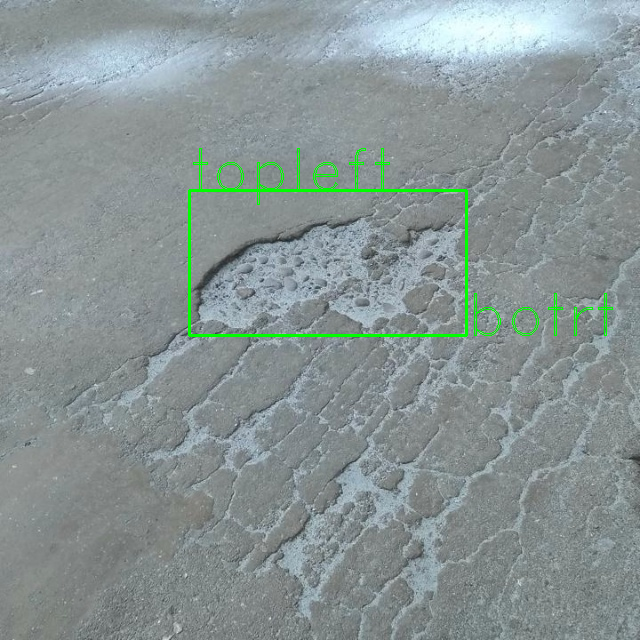

In [26]:
import cv2
from google.colab.patches import cv2_imshow

xmins =pothole_df.get('xmin')
ymins =pothole_df.get('ymin')
boxwidths =pothole_df.get('boxwidth')
boxheights =pothole_df.get('boxheight')
# Load an image


image_path = "data640/pothole/img-1.jpg"  # Provide your image path
image = cv2.imread(image_path)


# 198,213  545,430
# Define the top-left and bottom-right coordinates of the bounding box
top_left = (xmins[0],ymins[1])  # x, y coordinates
bottom_right = (xmins[0]+boxwidths[0],ymins[0]+boxheights[0])  # x, y coordinates

# Define the color and thickness of the bounding box
color = (0, 255, 0)  # Green in BGR format
thickness = 2  # Thickness of the rectangle border

# Draw the bounding box on the image
box_img = cv2.rectangle(image, top_left, bottom_right, color, thickness)

cv2.putText(image,"topleft",top_left,2,2,color)
cv2.putText(image,"botrt",bottom_right,2,2,color)
# Display the image with the bounding box
cv2_imshow(image)

# Wait for a key press and close the image window
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
classes=pothole_df['class'].unique().tolist()
classes

['pothole']

In [7]:
classMap={}
for i,cls in enumerate(classes):
  classMap[cls]=i

classMap

{'pothole': 0}

In [70]:
!rm -r runs

In [8]:
!mkdir pothole_data
!mkdir pothole_data/labels
!mkdir pothole_data/images
!mkdir pothole_data/images/train pothole_data/images/val pothole_data/images/test
!mkdir pothole_data/labels/train pothole_data/labels/val pothole_data/labels/test

In [9]:
imgs=pothole_df['filename'].unique().tolist()
for img in imgs:
  boundingDetails = []
  boundingInfo = pothole_df.loc[pothole_df.filename == img,:]
  for idx, row in boundingInfo.iterrows():
    class_id=classMap[row['class']]
    bb_width = row['boxwidth'] # row['xmax'] - row['xmin']
    bb_height = row['boxheight'] #  row['ymax'] - row['ymin']
    bb_xcentre = row['xmin'] + bb_width/2 # (row['xmin'] + row['xmax'])/2
    bb_ycentre = row['ymin'] + bb_height/2 # (row['ymin'] + row['ymax'])/2
    #normalize by dividing coordinates by width and height
    bb_xcentre /= row['width']
    bb_ycentre /= row['height']
    bb_width /= row['width']
    bb_height /= row['height']
    boundingDetails.append("{} {:3f} {:3f} {:3f} {:3f}".format(class_id, bb_xcentre, bb_ycentre, bb_width, bb_height))
    file_name = os.path.join('pothole_data/labels', img.split('.')[0]+'.txt')
    with open(file_name, 'w') as file:
      file.write("\n".join(boundingDetails))

In [10]:
annotations = glob.glob('pothole_data/labels'+'/*.txt')

In [11]:
imagePath = 'data640/pothole'
images = glob.glob(imagePath+'/*.jpg')

In [12]:
len(images)

100

In [13]:
images.sort()
annotations.sort()
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size=0.2)

In [14]:
def move_files_to_folder(list_of_files, destination_folder):
  for f in list_of_files:
    try:
      shutil.copy(f, destination_folder)
    except:
      print(f)
      assert False

In [15]:
#copy files to specified folder
move_files_to_folder(train_images, 'pothole_data/images/train')
move_files_to_folder(val_images, 'pothole_data/images/val')
move_files_to_folder(test_images, 'pothole_data/images/test')
move_files_to_folder(train_annotations, 'pothole_data/labels/train')
move_files_to_folder(val_annotations, 'pothole_data/labels/val')
move_files_to_folder(test_annotations, 'pothole_data/labels/test')

In [16]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [19]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8m.pt data=pothole.yaml epochs=20 imgsz=640 plots=True

/content
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=pothole.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

/content


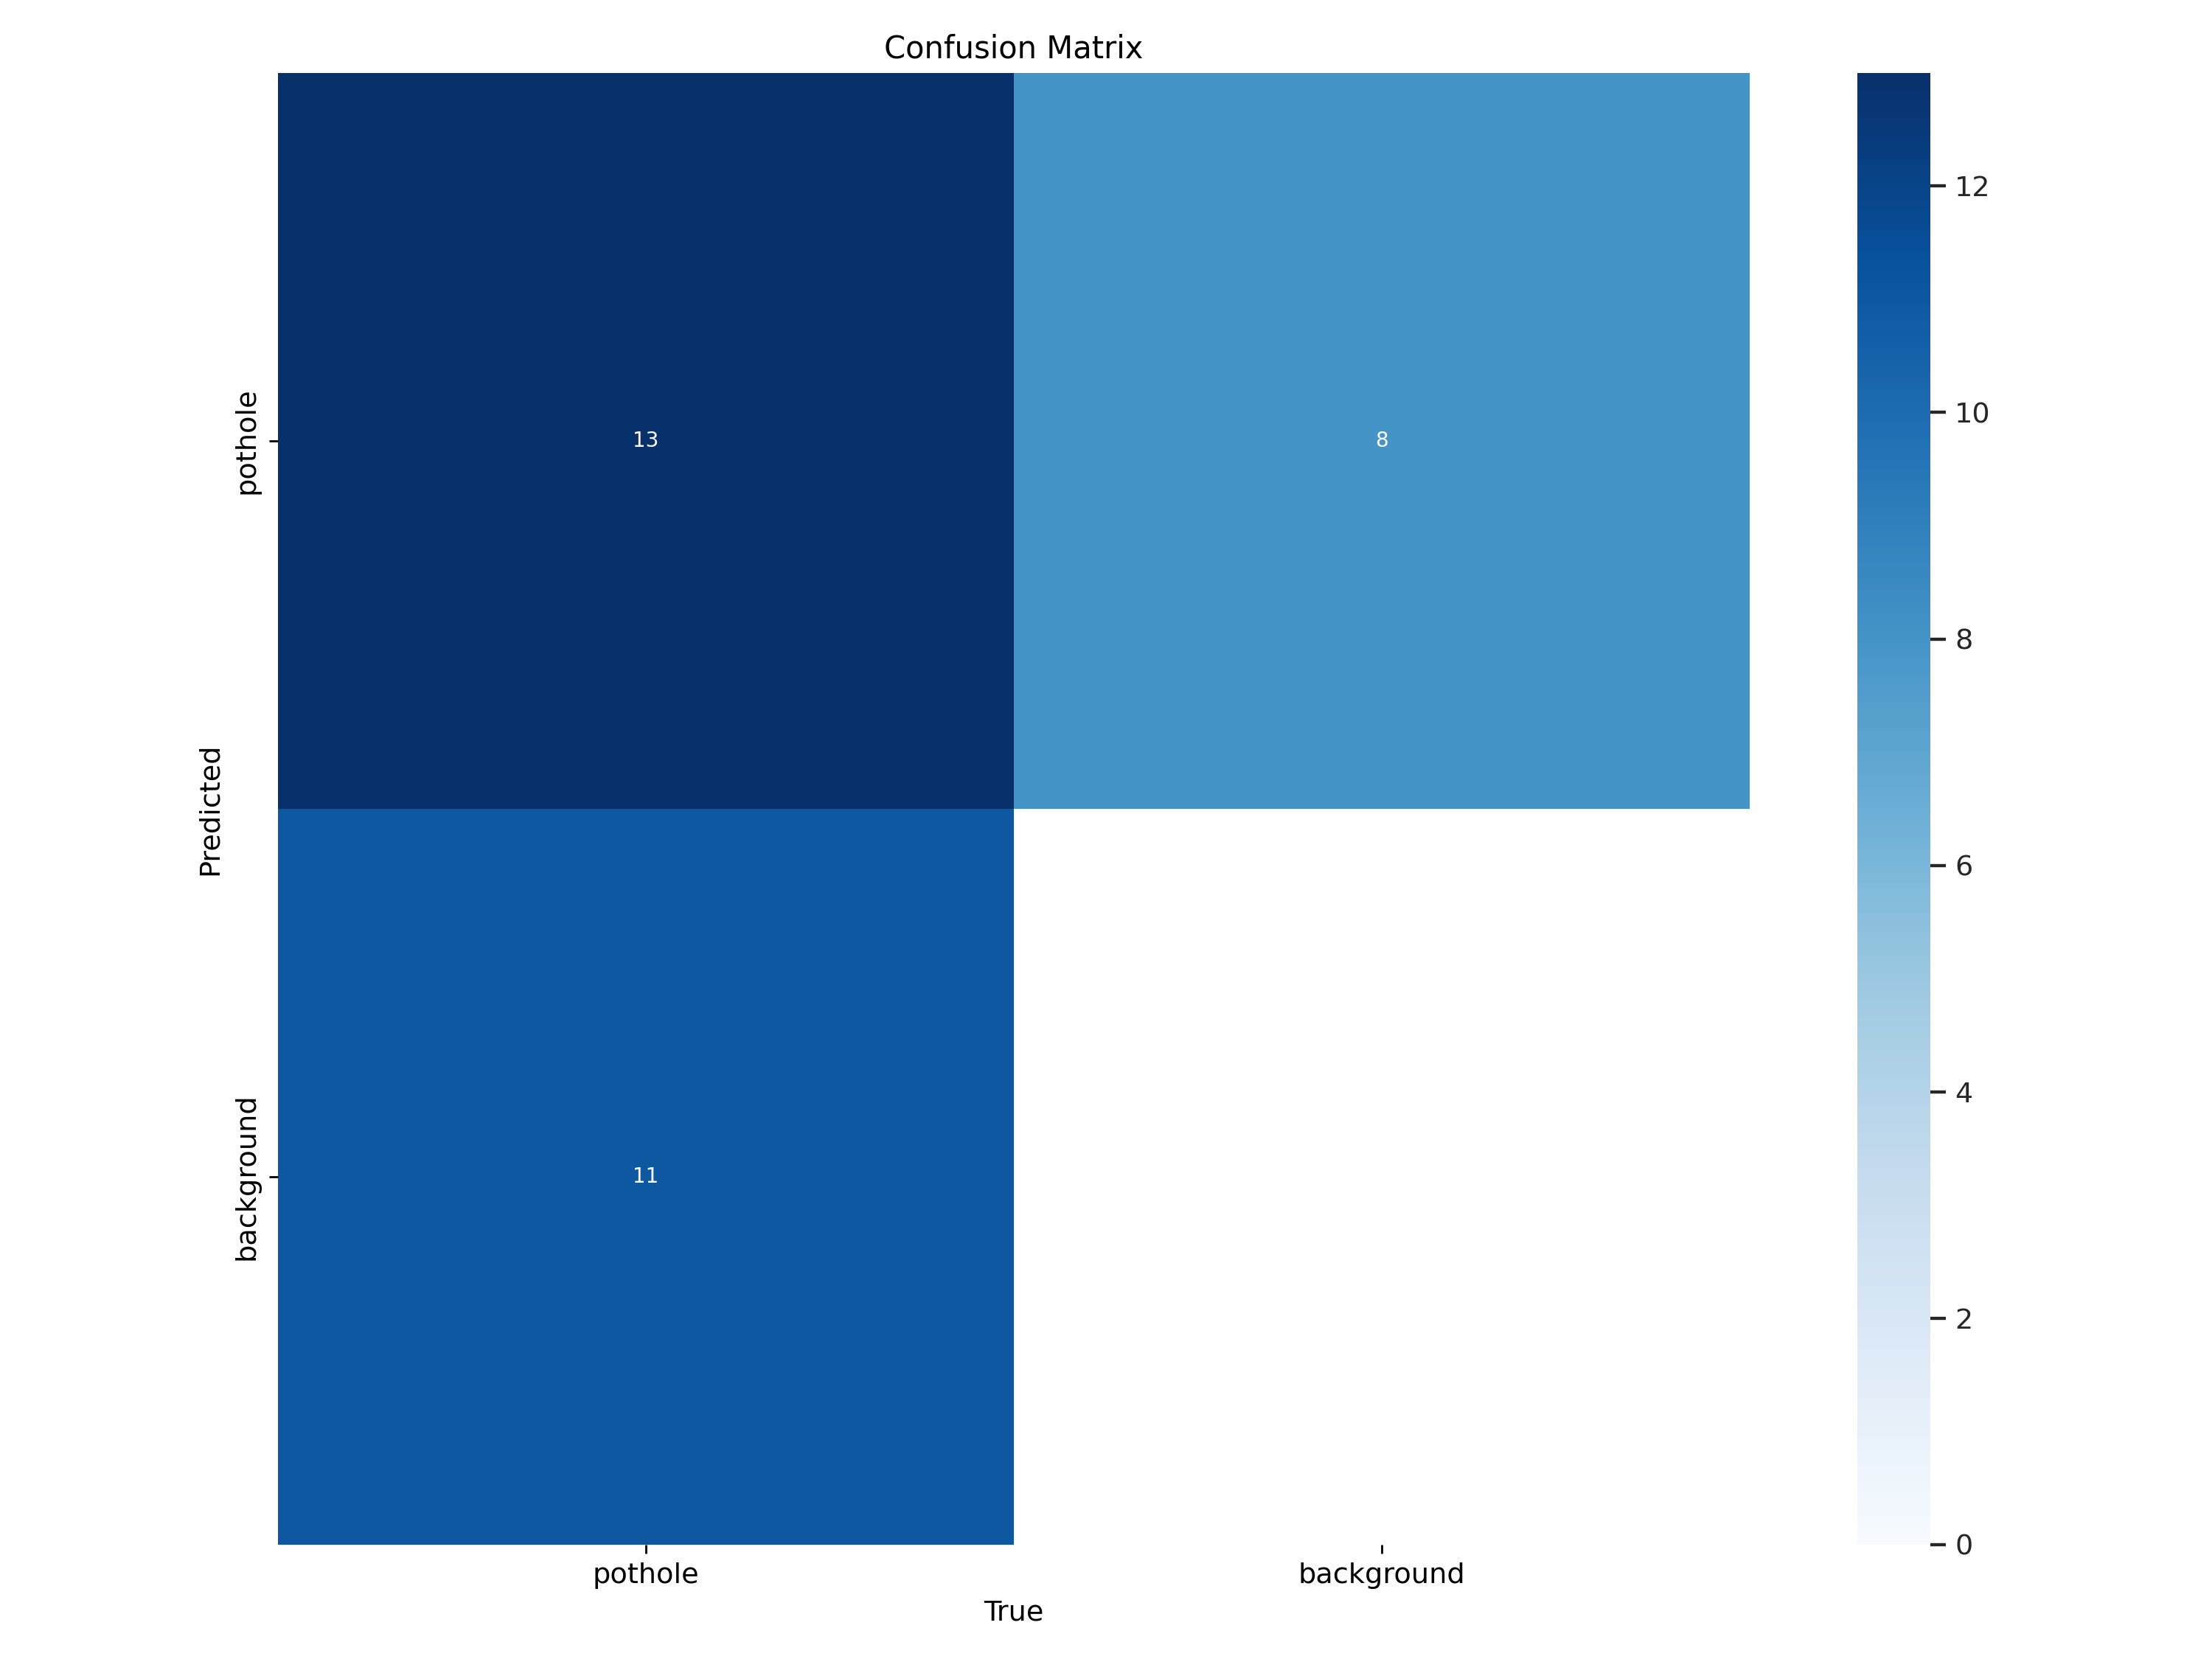

In [25]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix.png', width=600)

/content


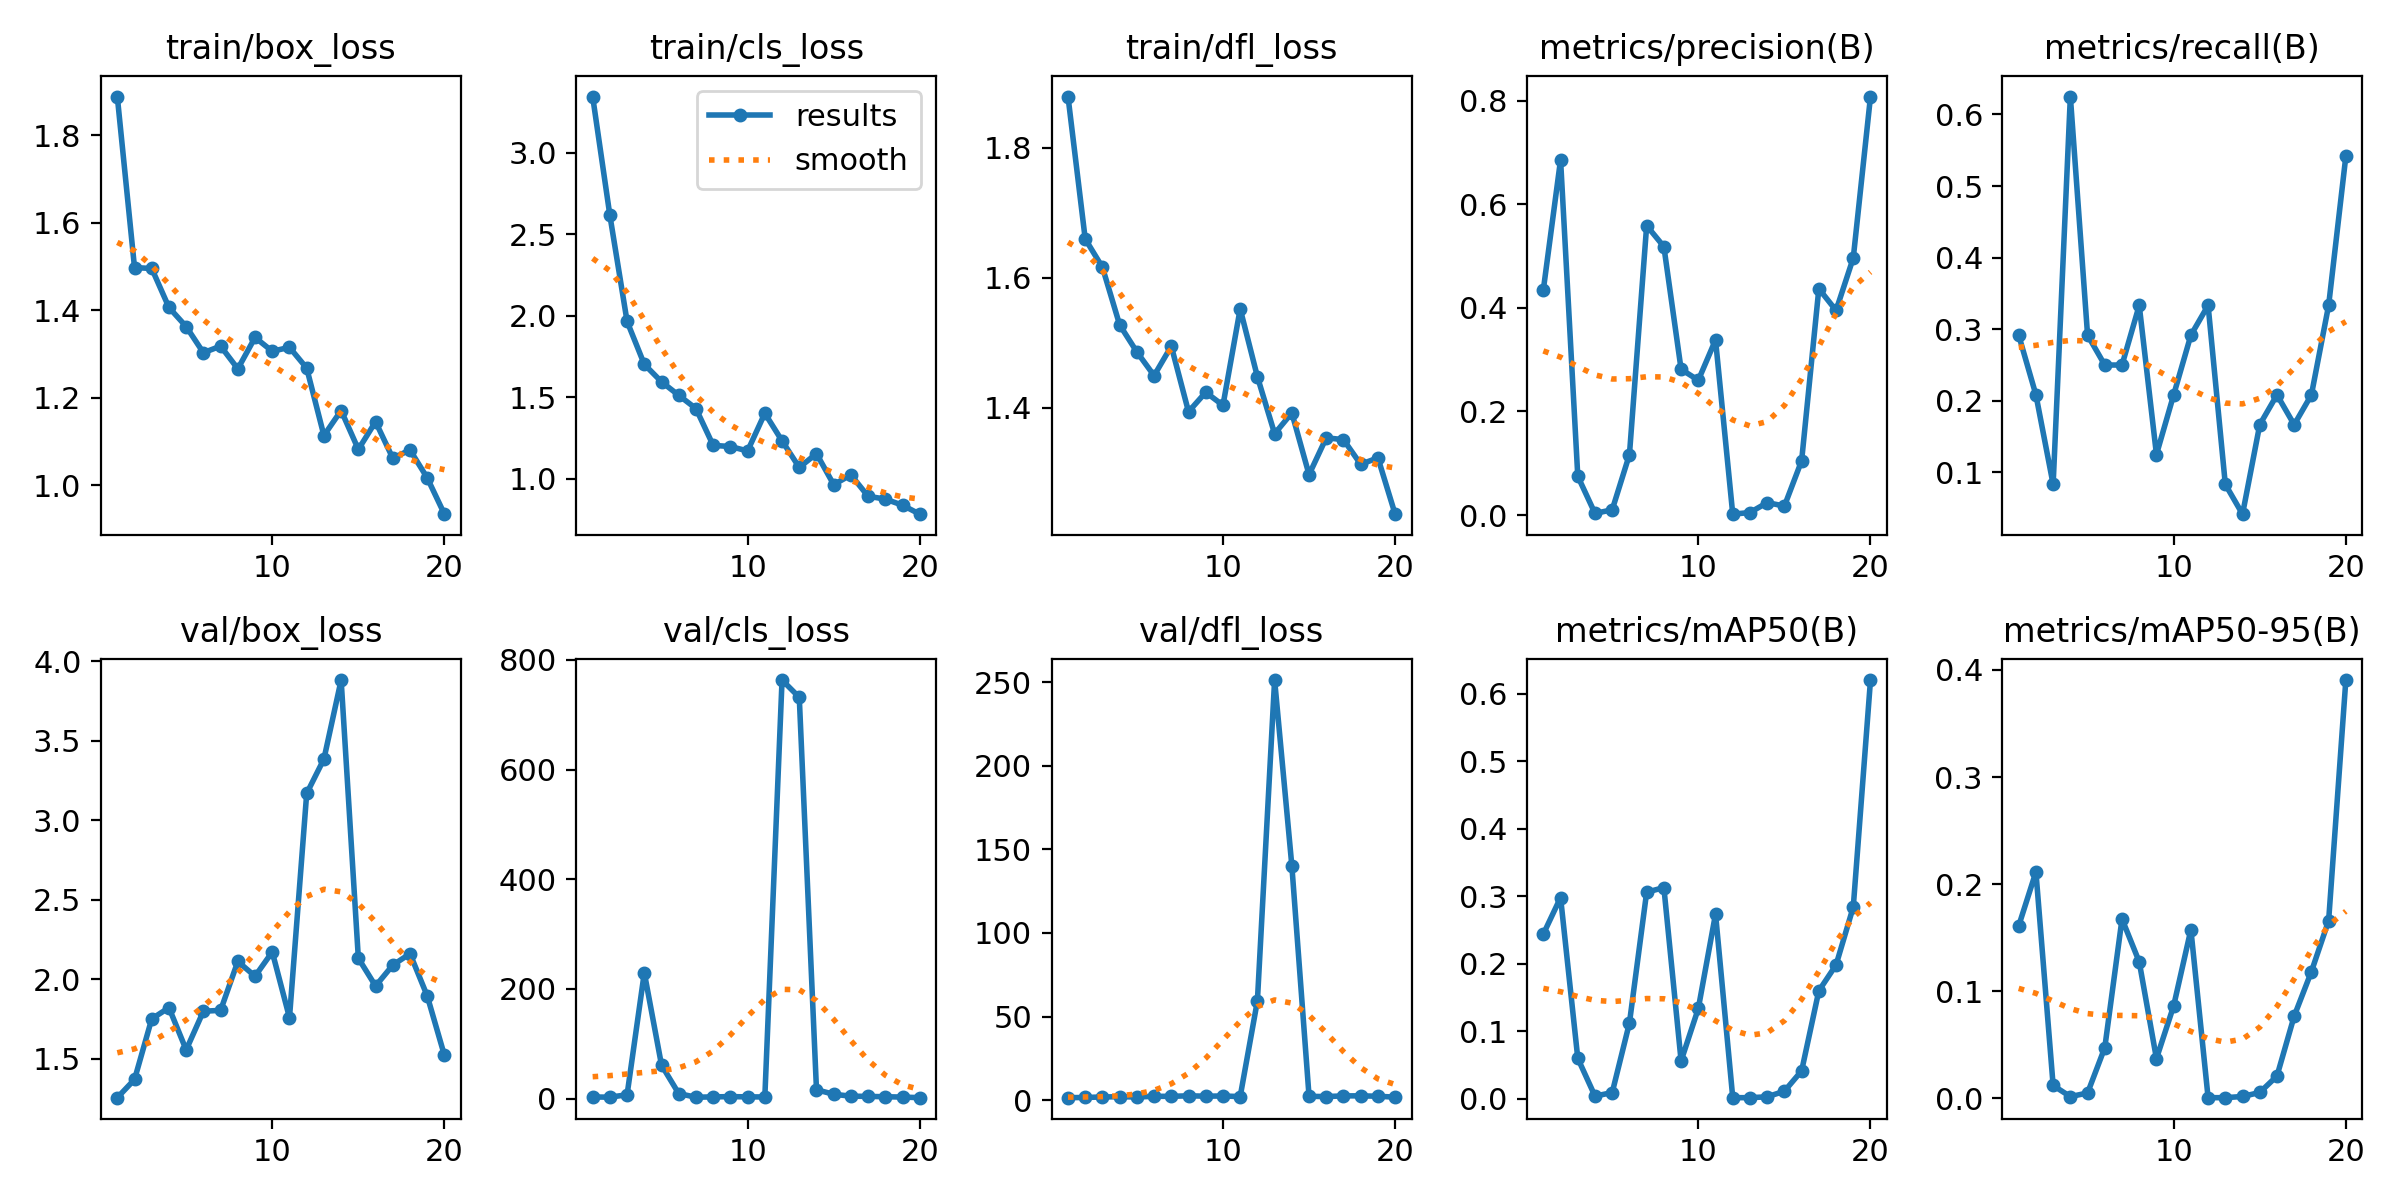

In [21]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/results.png', width=600)

/content


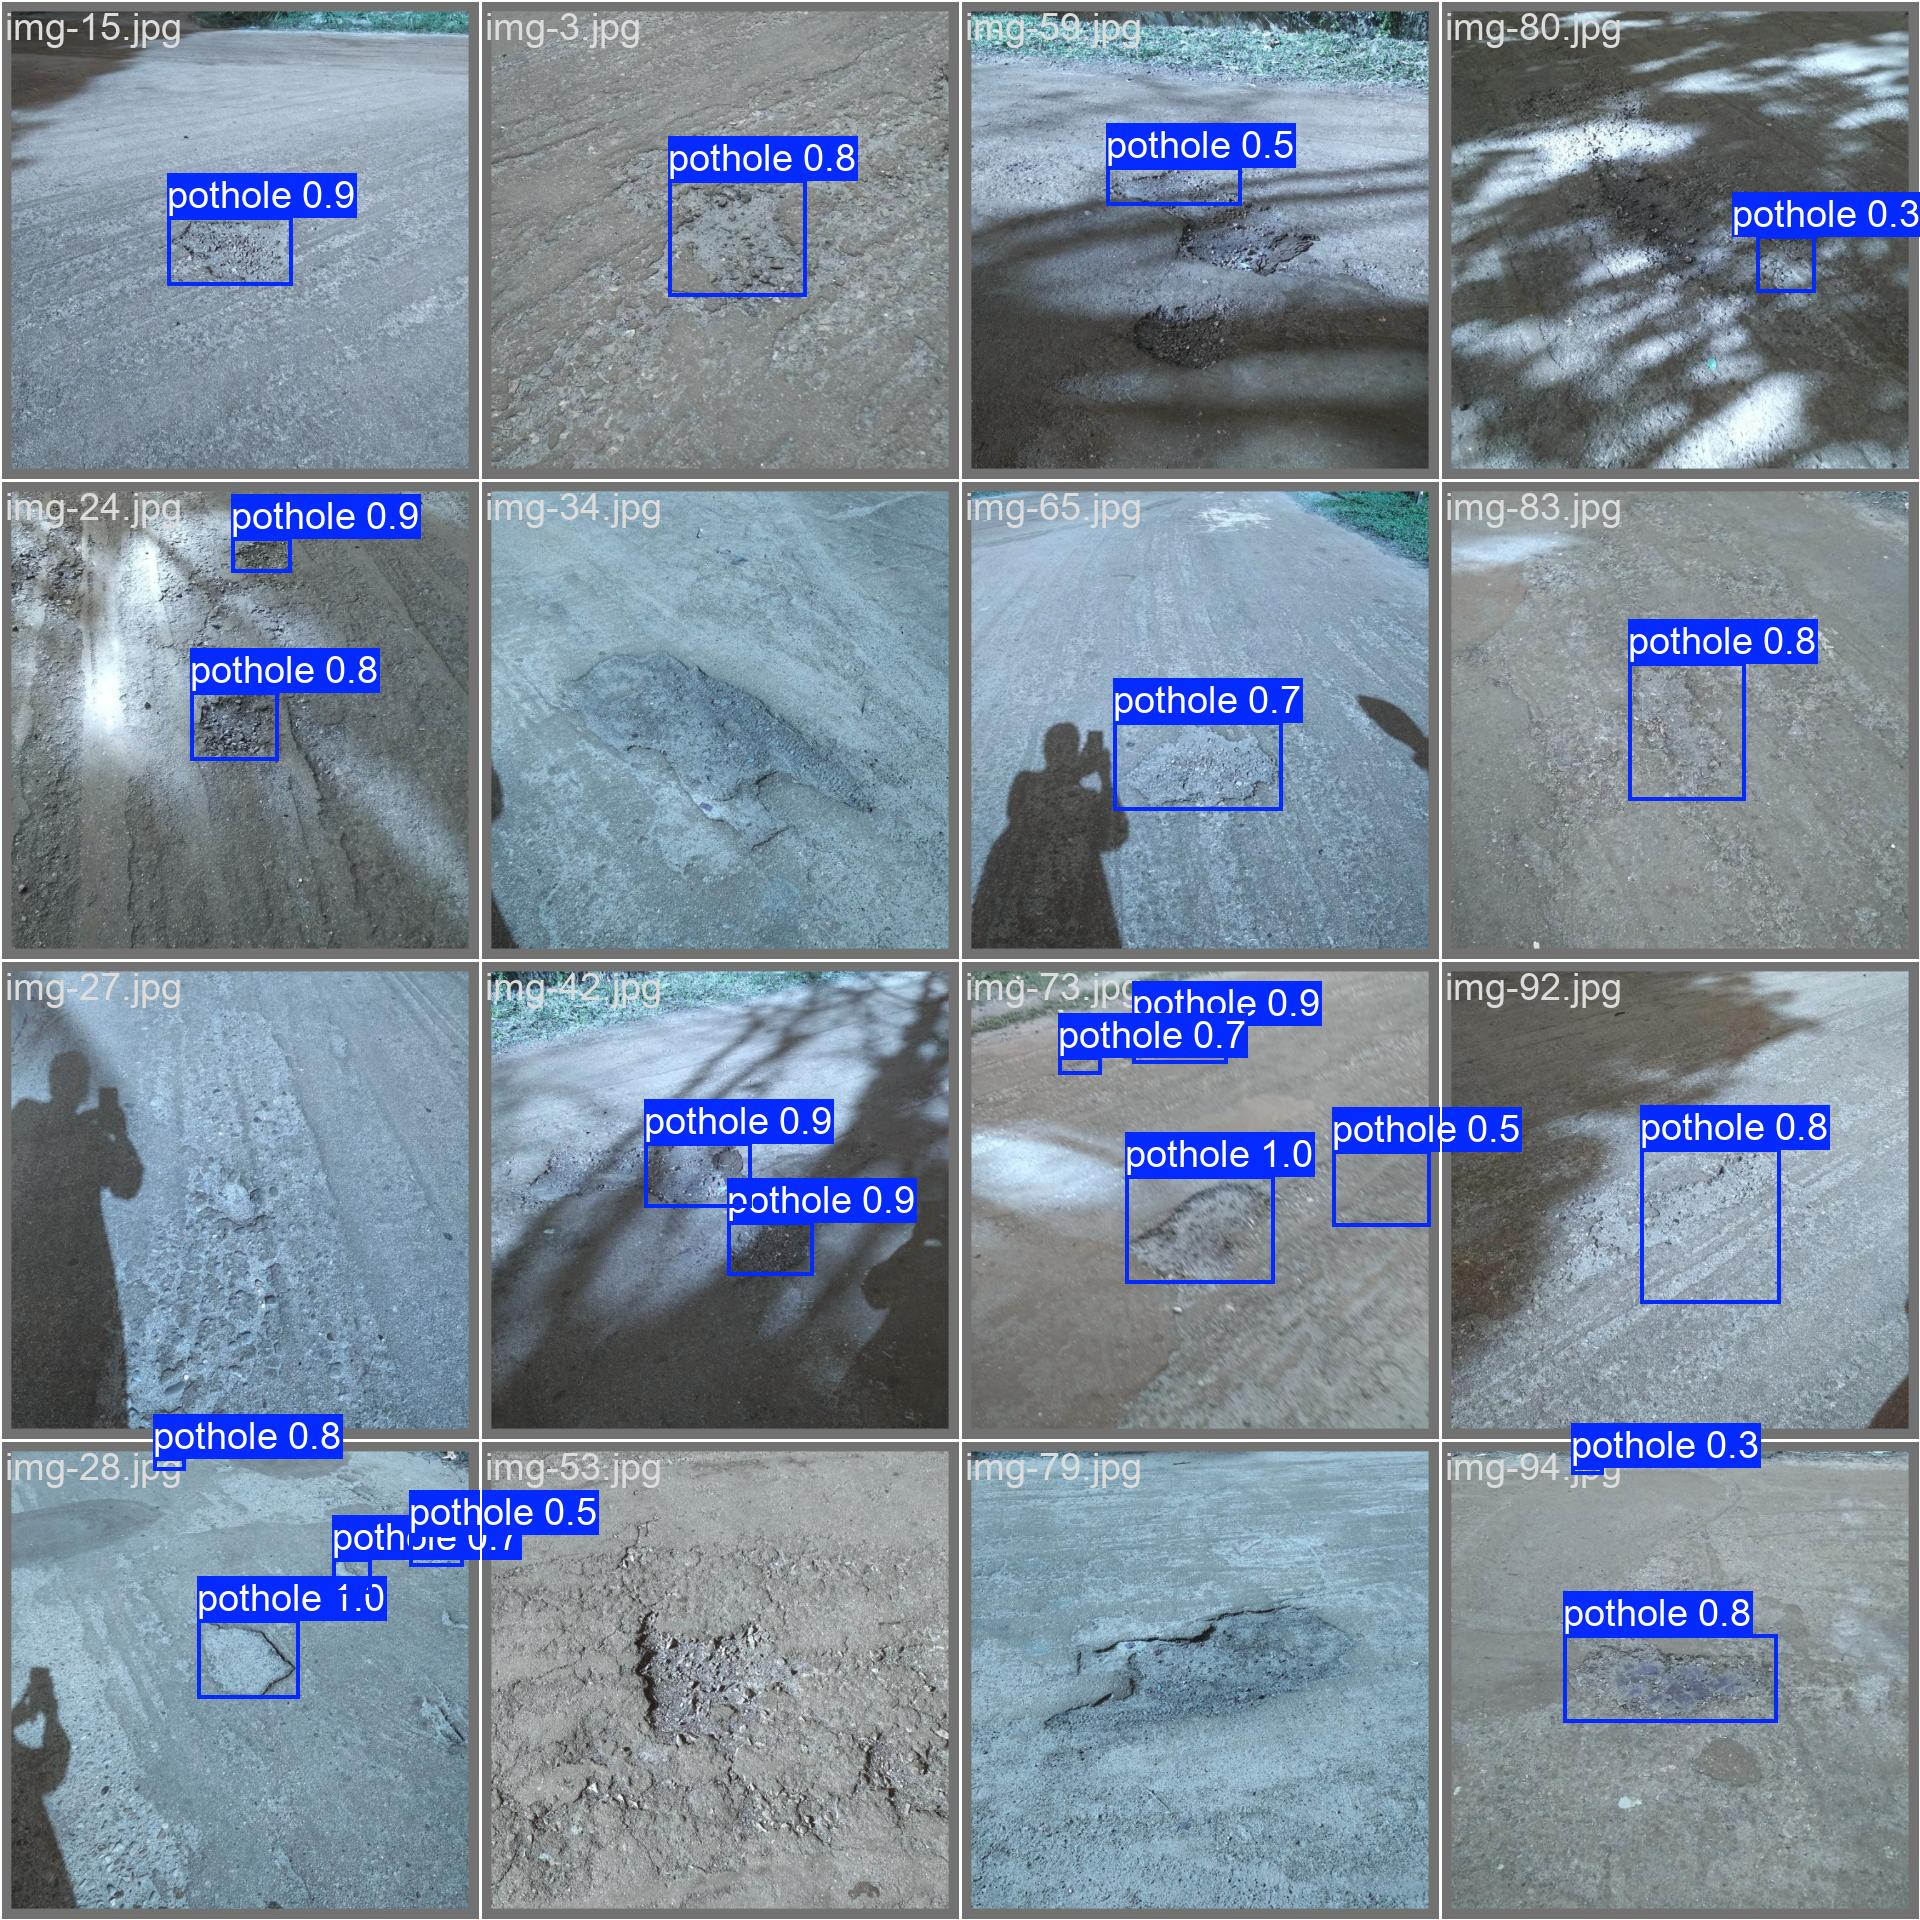

In [22]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/val_batch0_pred.jpg', width=600)

In [23]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train3/weights/best.pt data=pothole.yaml

/content
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/pothole_data/labels/val.cache... 16 images, 0 backgrounds, 0 corrupt: 100% 16/16 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:07<00:00,  7.59s/it]
                   all         16         24      0.808      0.542       0.62      0.394
Speed: 1.6ms preprocess, 462.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [24]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train3/weights/best.pt conf=0.25 source={HOME}/pothole_data/images/test save=True

/content
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs

image 1/4 /content/pothole_data/images/test/img-44.jpg: 640x640 2 potholes, 401.4ms
image 2/4 /content/pothole_data/images/test/img-61.jpg: 640x640 (no detections), 372.1ms
image 3/4 /content/pothole_data/images/test/img-68.jpg: 640x640 2 potholes, 326.2ms
image 4/4 /content/pothole_data/images/test/img-77.jpg: 640x640 6 potholes, 455.8ms
Speed: 1.8ms preprocess, 388.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict
